In [39]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 as cv
from skimage.util import img_as_ubyte, invert
from skimage import exposure
from skimage.transform import rescale


In [40]:
p_dir = (Path().cwd().parents[0]).absolute()

In [41]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
match_info_dir = p_dir / 'data' / 'registration'
experiment = 'Tonsil'
core = 'DonorE'

# Import IMC data 

In [43]:
from skimage.transform import rotate

h5_data_dir = p_dir / "data" / "h5"

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (1, 99))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


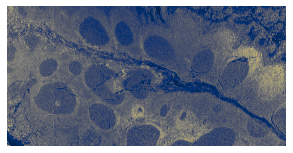

In [66]:
imgs, markers = get_imgs(f"{experiment} {core}", "IMC")
# subset = ["HistoneH3", 'SMA', 'COL1', 'DNA1']
# subset = ['COL1', 'DNA1', 'DNA2', 'Ki67', 'CD21', 'Vimentin']
subset = [ 'DNA1', 'DNA2', 'Vimentin', 'H3K27me3']
img_dapi = np.max(contrast_stretching(imgs[[markers.index(marker) for marker in subset]]), axis=0)
img_dapi = contrast_stretching(img_dapi, )

rotation_imc = 90
img_h3 = rotate(img_dapi, rotation_imc, resize=True)
img_h3 = img_h3

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img_h3, cmap='cividis')
ax.axis('off')
plt.show()

# Read H&E image

In [56]:
he_resolution =  0.37744 # um/pixel

C:\Users\thu71\AppData\Local\Temp/ipykernel_36944/1050191473.py:8: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)


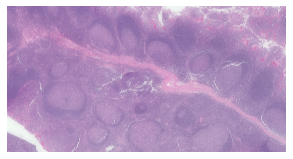

In [57]:
HE_path = p_dir / 'data' / 'HE' 
img_he_path = HE_path / f'{core}.tif'

img_he = invert(io.imread(img_he_path, as_gray=True))
img_he_rescale = rescale(img_he, he_resolution)

img_he_rgb = io.imread(img_he_path, as_gray=False)
img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img_he_rgb_rescale)
ax.axis('off')
plt.show()

# Template matching

In [67]:
from skimage.feature import match_template
from skimage.transform import rescale
from typing import Tuple

def match_region(source: np.ndarray, template: np.ndarray, show: bool=True) -> Tuple[np.ndarray, Tuple[int, int, int, int]]:
    '''
    Template matching between source and template
    Return cropped source matching template and bbox of crop region
    '''

    # Use template matching
    result = match_template(source, template)

    # Get maximum point of correlation
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    h_region, w_region =  template.shape
    
    if show: 
        # Plot result
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(source, cmap=plt.cm.gray)
        ax.set_axis_off()

        # highlight matched region
        rect = plt.Rectangle((x, y), w_region, h_region, edgecolor='r', facecolor='none', lw=3)
        ax.add_patch(rect)
    
    img_crop = source[y:y+h_region, x:x+w_region]

    return img_crop, (y, h_region, x, w_region)


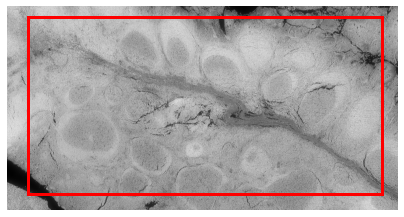

In [68]:
img_he_crop, bbox = match_region(img_he_rescale, img_h3)
plt.show()

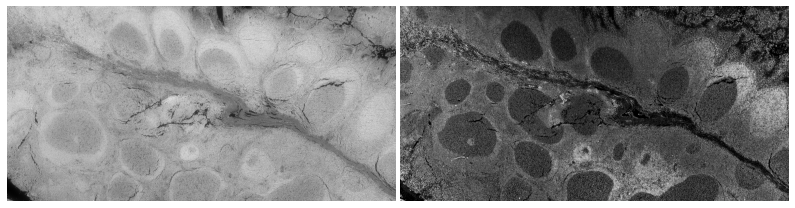

In [69]:
y, h_region, x, w_region = np.array(bbox)
img_he_rgb_crop = img_he_rgb_rescale[y:y+h_region, x:x+w_region]

fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].imshow(img_he_crop, cmap='gray')
ax[1].imshow(img_h3, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
fig.subplots_adjust(wspace=0.01)
plt.show()

## Calculate rotation

In [70]:
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
import matplotlib.patches as mpatches
from collections import Counter
import matplotlib.offsetbox
from matplotlib.lines import Line2D

def get_rotation(source: np.ndarray, template: np.ndarray, radius:int = 720) -> int:
    '''
    Calculate rotation angle between source and template in degrees
    '''
    
    image_polar = warp_polar(source, radius=radius)
    rotated_polar = warp_polar(template, radius=radius)

    shifts, error, phasediff = phase_cross_correlation(image_polar, rotated_polar, upsample_factor=10)
    print("Recovered value for counterclockwise rotation: "
          f"{shifts[0]}")
    
    return shifts[0]


class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, textprops={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False, textprops=textprops)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)


In [72]:
rotation = get_rotation(img_he_crop, img_h3, radius=90)
# rotation = 1

Recovered value for counterclockwise rotation: -122.2


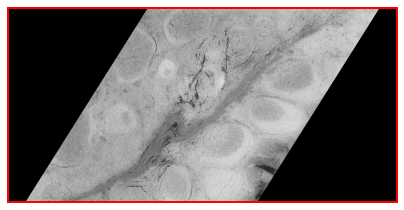

In [73]:
y, h_region, x, w_region = np.array(bbox) + np.array([-20, 20, -20, 20])
res, bbox_r= match_region(rotate(img_he_rescale[y:y+h_region, x:x+w_region], rotation), img_h3)

In [ ]:
y, h_region, x, w_region = np.array(bbox) + np.array([-20, 20, -20, 20])
img = rotate(img_he_rgb_rescale[y:y+h_region, x:x+w_region], rotation)
y, h_region, x, w_region = np.array(bbox_r)
img = img[y:y+h_region, x:x+w_region,:]

fig, ax = plt.subplots(1, 2, figsize=(14,7), facecolor='black')
ax[0].imshow(img)
ax[1].imshow(img_h3, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
# Add Scale Bar
ob = AnchoredHScaleBar(size=200, label="150\u03BCm", loc=4, frameon=False, extent=0.,
               pad=0.1,sep=4, linekw=dict(color="w", linewidth=5), textprops=dict(color='w',fontsize=20))
ax[1].add_artist(ob)
fig.subplots_adjust(wspace=0.01)
plt.show()

## Save image
# file_path = Path.cwd().parent / 'figures' / 'HE_registration' / f'{core}.png'
# fig.savefig(file_path, dpi=500, bbox_inches='tight', pad_inches=0)

In [ ]:
# from skimage.color import rgb2gray
# napari.view_image(np.stack([rgb2gray(img), img_h3]))

In [ ]:
# from skimage.color import rgb2gray
# rotation = get_rotation(invert(rgb2gray(img)), img_h3)


In [151]:
info = {'rotation': rotation-rotation_imc, 'bbox': bbox, 'bbox_r': bbox_r}
my_utils.save_pkl(match_info_dir / f'{core}_HE_IMC.pickle', info)